##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in two ways. First, you will use high-level Keras preprocessing [utilities](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) and [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing). Next, you will write your own input pipeline from scratch using [tf.data](https://www.tensorflow.org/guide/data).

## Setup

In [2]:
!pip install -q tf-nightly

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [4]:
print(tf.__version__)

2.4.0-dev20200720


## Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains 5 sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

After downloading (218MB), you should now have a copy of the flower photos available. There are 3670 total images:

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

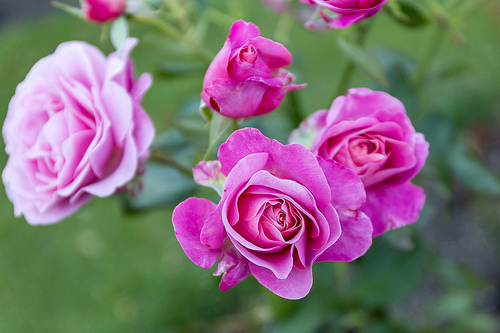

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

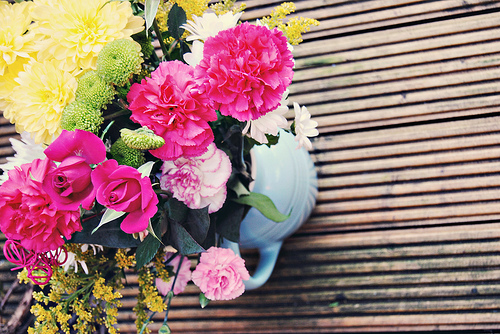

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# Load using keras.preprocessing

Let's load these images off disk using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

Note: The Keras Preprocesing utilities and layers introduced in this section are currently experimental and may change.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

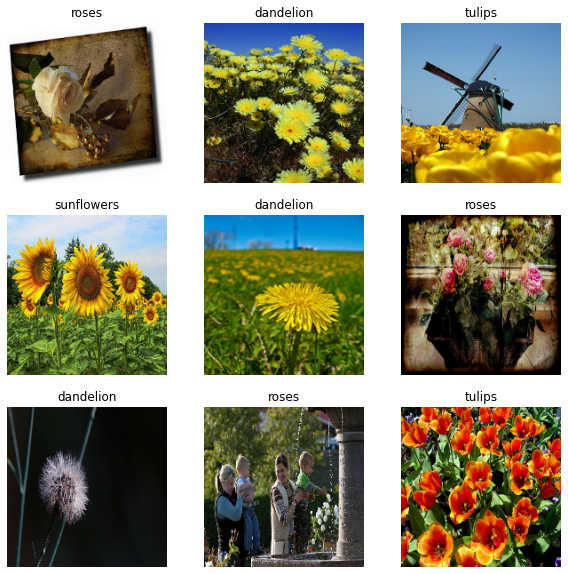

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 


Note: you can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

## Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [15]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `Rescaling(1./127.5, offset=-1)`

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer instead.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a model

For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this [tutorial](https://www.tensorflow.org/tutorials/images/classification).

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: we will only train for a few epochs so this tutorial runs quickly. 

In [20]:
model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 0s - loss: 1.6217 - accuracy: 0.1562

 3/92 [..............................] - ETA: 2s - loss: 1.8324 - accuracy: 0.3125

 4/92 [>.............................] - ETA: 2s - loss: 1.7763 - accuracy: 0.2969

 5/92 [>.............................] - ETA: 3s - loss: 1.7508 - accuracy: 0.2750

 6/92 [>.............................] - ETA: 3s - loss: 1.7359 - accuracy: 0.2917

 7/92 [=>............................] - ETA: 3s - loss: 1.7060 - accuracy: 0.3036

 8/92 [=>............................] - ETA: 3s - loss: 1.6850 - accuracy: 0.3008

 9/92 [=>............................] - ETA: 3s - loss: 1.6668 - accuracy: 0.3125

11/92 [==>...........................] - ETA: 3s - loss: 1.6447 - accuracy: 0.3153

12/92 [==>...........................] - ETA: 3s - loss: 1.6315 - accuracy: 0.3125

13/92 [===>..........................] - ETA: 3s - loss: 1.6239 - accuracy: 0.3101

14/92 [===>..........................] - ETA: 3s - loss: 1.6128 - accuracy: 0.3080

16/92 [====>.........................] - ETA: 3s - loss: 1.6001 - accuracy: 0.3066

17/92 [====>.........................] - ETA: 3s - loss: 1.5962 - accuracy: 0.3051

18/92 [====>.........................] - ETA: 3s - loss: 1.5892 - accuracy: 0.3056

19/92 [=====>........................] - ETA: 3s - loss: 1.5833 - accuracy: 0.3092

20/92 [=====>........................] - ETA: 3s - loss: 1.5754 - accuracy: 0.3156

21/92 [=====>........................] - ETA: 3s - loss: 1.5668 - accuracy: 0.3229

22/92 [======>.......................] - ETA: 3s - loss: 1.5560 - accuracy: 0.3267

23/92 [======>.......................] - ETA: 3s - loss: 1.5470 - accuracy: 0.3329

25/92 [=======>......................] - ETA: 3s - loss: 1.5354 - accuracy: 0.3388

26/92 [=======>......................] - ETA: 3s - loss: 1.5256 - accuracy: 0.3462

27/92 [=======>......................] - ETA: 3s - loss: 1.5222 - accuracy: 0.3495

29/92 [========>.....................] - ETA: 3s - loss: 1.5095 - accuracy: 0.3545

30/92 [========>.....................] - ETA: 3s - loss: 1.5054 - accuracy: 0.3594

31/92 [=========>....................] - ETA: 3s - loss: 1.4973 - accuracy: 0.3609

32/92 [=========>....................] - ETA: 3s - loss: 1.4884 - accuracy: 0.3643

34/92 [==========>...................] - ETA: 2s - loss: 1.4823 - accuracy: 0.3621

36/92 [==========>...................] - ETA: 2s - loss: 1.4616 - accuracy: 0.3733

37/92 [===========>..................] - ETA: 2s - loss: 1.4545 - accuracy: 0.3784

38/92 [===========>..................] - ETA: 2s - loss: 1.4477 - accuracy: 0.3832

40/92 [============>.................] - ETA: 2s - loss: 1.4383 - accuracy: 0.3883

41/92 [============>.................] - ETA: 2s - loss: 1.4299 - accuracy: 0.3910

42/92 [============>.................] - ETA: 2s - loss: 1.4237 - accuracy: 0.3951

43/92 [=============>................] - ETA: 2s - loss: 1.4189 - accuracy: 0.3939

45/92 [=============>................] - ETA: 2s - loss: 1.4085 - accuracy: 0.3972

46/92 [==============>...............] - ETA: 2s - loss: 1.4084 - accuracy: 0.3947

47/92 [==============>...............] - ETA: 2s - loss: 1.4073 - accuracy: 0.3989

48/92 [==============>...............] - ETA: 2s - loss: 1.4074 - accuracy: 0.3984

50/92 [===============>..............] - ETA: 2s - loss: 1.4008 - accuracy: 0.3994

51/92 [===============>..............] - ETA: 2s - loss: 1.3989 - accuracy: 0.3983

52/92 [===============>..............] - ETA: 2s - loss: 1.3960 - accuracy: 0.4002

53/92 [================>.............] - ETA: 2s - loss: 1.3945 - accuracy: 0.4009

54/92 [================>.............] - ETA: 1s - loss: 1.3910 - accuracy: 0.4051

55/92 [================>.............] - ETA: 1s - loss: 1.3843 - accuracy: 0.4097

57/92 [=================>............] - ETA: 1s - loss: 1.3799 - accuracy: 0.4128

58/92 [=================>............] - ETA: 1s - loss: 1.3809 - accuracy: 0.4133

60/92 [==================>...........] - ETA: 1s - loss: 1.3749 - accuracy: 0.4156

61/92 [==================>...........] - ETA: 1s - loss: 1.3718 - accuracy: 0.4191

62/92 [===================>..........] - ETA: 1s - loss: 1.3666 - accuracy: 0.4229

64/92 [===================>..........] - ETA: 1s - loss: 1.3569 - accuracy: 0.4263

65/92 [====================>.........] - ETA: 1s - loss: 1.3548 - accuracy: 0.4260

66/92 [====================>.........] - ETA: 1s - loss: 1.3547 - accuracy: 0.4257

68/92 [=====================>........] - ETA: 1s - loss: 1.3459 - accuracy: 0.4274

69/92 [=====================>........] - ETA: 1s - loss: 1.3470 - accuracy: 0.4275

70/92 [=====================>........] - ETA: 1s - loss: 1.3461 - accuracy: 0.4281

71/92 [======================>.......] - ETA: 1s - loss: 1.3399 - accuracy: 0.4305

72/92 [======================>.......] - ETA: 1s - loss: 1.3336 - accuracy: 0.4332

73/92 [======================>.......] - ETA: 0s - loss: 1.3298 - accuracy: 0.4354

74/92 [=======================>......] - ETA: 0s - loss: 1.3258 - accuracy: 0.4362

75/92 [=======================>......] - ETA: 0s - loss: 1.3252 - accuracy: 0.4375

76/92 [=======================>......] - ETA: 0s - loss: 1.3286 - accuracy: 0.4383

77/92 [========================>.....] - ETA: 0s - loss: 1.3250 - accuracy: 0.4399

78/92 [========================>.....] - ETA: 0s - loss: 1.3217 - accuracy: 0.4423

79/92 [========================>.....] - ETA: 0s - loss: 1.3223 - accuracy: 0.4426

81/92 [=========================>....] - ETA: 0s - loss: 1.3182 - accuracy: 0.4444

82/92 [=========================>....] - ETA: 0s - loss: 1.3185 - accuracy: 0.4451

83/92 [==========================>...] - ETA: 0s - loss: 1.3162 - accuracy: 0.4462

86/92 [===========================>..] - ETA: 0s - loss: 1.3073 - accuracy: 0.4509

92/92 [==============================] - ETA: 0s - loss: 1.3146 - accuracy: 0.4475

92/92 [==============================] - 6s 63ms/step - loss: 1.3146 - accuracy: 0.4475 - val_loss: 1.0906 - val_accuracy: 0.5668


Epoch 2/3
 1/92 [..............................] - ETA: 0s - loss: 1.1791 - accuracy: 0.5938

 7/92 [=>............................] - ETA: 0s - loss: 1.1701 - accuracy: 0.5000

13/92 [===>..........................] - ETA: 0s - loss: 1.1421 - accuracy: 0.5144

19/92 [=====>........................] - ETA: 0s - loss: 1.1135 - accuracy: 0.5329

25/92 [=======>......................] - ETA: 0s - loss: 1.1084 - accuracy: 0.5250

31/92 [=========>....................] - ETA: 0s - loss: 1.0970 - accuracy: 0.5393

37/92 [===========>..................] - ETA: 0s - loss: 1.0732 - accuracy: 0.5490

43/92 [=============>................] - ETA: 0s - loss: 1.0612 - accuracy: 0.5574

49/92 [==============>...............] - ETA: 0s - loss: 1.0608 - accuracy: 0.5580

55/92 [================>.............] - ETA: 0s - loss: 1.0578 - accuracy: 0.5608

61/92 [==================>...........] - ETA: 0s - loss: 1.0605 - accuracy: 0.5615

67/92 [====================>.........] - ETA: 0s - loss: 1.0543 - accuracy: 0.5658

73/92 [======================>.......] - ETA: 0s - loss: 1.0484 - accuracy: 0.5676

79/92 [========================>.....] - ETA: 0s - loss: 1.0494 - accuracy: 0.5680

85/92 [==========================>...] - ETA: 0s - loss: 1.0514 - accuracy: 0.5684

91/92 [============================>.] - ETA: 0s - loss: 1.0598 - accuracy: 0.5663

92/92 [==============================] - 1s 10ms/step - loss: 1.0615 - accuracy: 0.5647 - val_loss: 1.0139 - val_accuracy: 0.5763


Epoch 3/3


 1/92 [..............................] - ETA: 0s - loss: 1.1222 - accuracy: 0.5625

 7/92 [=>............................] - ETA: 0s - loss: 0.9556 - accuracy: 0.6696

13/92 [===>..........................] - ETA: 0s - loss: 0.9487 - accuracy: 0.6418

19/92 [=====>........................] - ETA: 0s - loss: 0.9400 - accuracy: 0.6414

25/92 [=======>......................] - ETA: 0s - loss: 0.9231 - accuracy: 0.6513

31/92 [=========>....................] - ETA: 0s - loss: 0.9101 - accuracy: 0.6552

37/92 [===========>..................] - ETA: 0s - loss: 0.8979 - accuracy: 0.6546

43/92 [=============>................] - ETA: 0s - loss: 0.8953 - accuracy: 0.6512

49/92 [==============>...............] - ETA: 0s - loss: 0.8997 - accuracy: 0.6460

55/92 [================>.............] - ETA: 0s - loss: 0.8939 - accuracy: 0.6517

61/92 [==================>...........] - ETA: 0s - loss: 0.8993 - accuracy: 0.6511

67/92 [====================>.........] - ETA: 0s - loss: 0.8916 - accuracy: 0.6544

73/92 [======================>.......] - ETA: 0s - loss: 0.8875 - accuracy: 0.6554

79/92 [========================>.....] - ETA: 0s - loss: 0.8901 - accuracy: 0.6543

85/92 [==========================>...] - ETA: 0s - loss: 0.8914 - accuracy: 0.6537

91/92 [============================>.] - ETA: 0s - loss: 0.8971 - accuracy: 0.6518

92/92 [==============================] - 1s 10ms/step - loss: 0.8982 - accuracy: 0.6512 - val_loss: 0.9394 - val_accuracy: 0.6390


Note: you can also write a custom training loop instead of using `model.fit`. To learn more, visit this [tutorial](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch).

You may notice the validation accuracy is low to the compared to the training accuracy, indicating our model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

# Using tf.data for finer control

The above keras.preprocessing utilities are a convenient way to create a `tf.data.Dataset` from a directory of imgages. For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.

In [21]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [22]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/tulips/8555123165_2fe57eff4f.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/5435521200_92029bbe2b_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/2963905796_227d37ff12.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/roses/6105809987_8f3d7a8d67_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/sunflowers/20965412955_2c640b13bd.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [23]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation:

In [24]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can see the length of each dataset as follows:

In [25]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [26]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [27]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [28]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


## Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, see the [Input Pipeline Performance](../../guide/performance/datasets) guide.

In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualize the data

You can visualize this dataset similarly to the one you created previously.

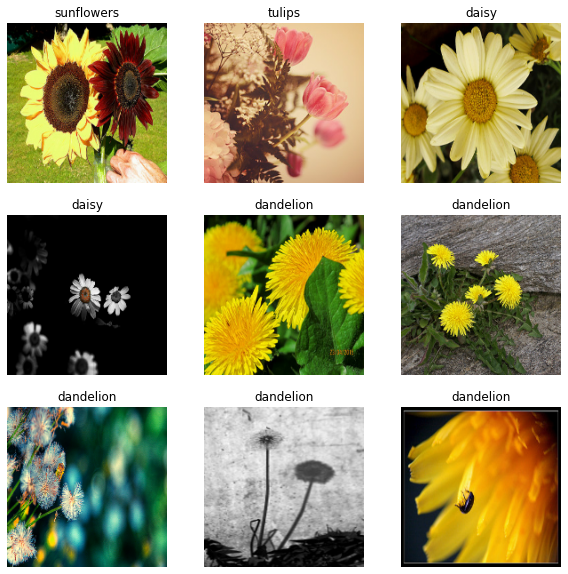

In [32]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by the `keras.preprocessing` above. You can continue training the model with it. As before, we will train for just a few epochs to keep the running time short.

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 0s - loss: 1.0322 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 1s - loss: 0.8656 - accuracy: 0.6750

 9/92 [=>............................] - ETA: 1s - loss: 0.8793 - accuracy: 0.6528

13/92 [===>..........................] - ETA: 1s - loss: 0.8616 - accuracy: 0.6683

17/92 [====>.........................] - ETA: 1s - loss: 0.8516 - accuracy: 0.6857

21/92 [=====>........................] - ETA: 0s - loss: 0.8045 - accuracy: 0.7039

25/92 [=======>......................] - ETA: 0s - loss: 0.7885 - accuracy: 0.7075

29/92 [========>.....................] - ETA: 0s - loss: 0.7841 - accuracy: 0.7004

33/92 [=========>....................] - ETA: 0s - loss: 0.7782 - accuracy: 0.7036

37/92 [===========>..................] - ETA: 0s - loss: 0.7671 - accuracy: 0.7061

41/92 [============>.................] - ETA: 0s - loss: 0.7596 - accuracy: 0.7073

45/92 [=============>................] - ETA: 0s - loss: 0.7805 - accuracy: 0.7021

49/92 [==============>...............] - ETA: 0s - loss: 0.7673 - accuracy: 0.7060

53/92 [================>.............] - ETA: 0s - loss: 0.7685 - accuracy: 0.7058

57/92 [=================>............] - ETA: 0s - loss: 0.7763 - accuracy: 0.7023

62/92 [===================>..........] - ETA: 0s - loss: 0.7774 - accuracy: 0.6996

67/92 [====================>.........] - ETA: 0s - loss: 0.7786 - accuracy: 0.6978

73/92 [======================>.......] - ETA: 0s - loss: 0.7786 - accuracy: 0.6965

79/92 [========================>.....] - ETA: 0s - loss: 0.7800 - accuracy: 0.6978

85/92 [==========================>...] - ETA: 0s - loss: 0.7799 - accuracy: 0.7004

91/92 [============================>.] - ETA: 0s - loss: 0.7861 - accuracy: 0.6985

92/92 [==============================] - 2s 19ms/step - loss: 0.7854 - accuracy: 0.6982 - val_loss: 0.7627 - val_accuracy: 0.7030


Epoch 2/3
 1/92 [..............................] - ETA: 0s - loss: 0.5605 - accuracy: 0.7500

 7/92 [=>............................] - ETA: 0s - loss: 0.5782 - accuracy: 0.7991

13/92 [===>..........................] - ETA: 0s - loss: 0.5968 - accuracy: 0.7885

19/92 [=====>........................] - ETA: 0s - loss: 0.6031 - accuracy: 0.7862

25/92 [=======>......................] - ETA: 0s - loss: 0.5858 - accuracy: 0.7950

31/92 [=========>....................] - ETA: 0s - loss: 0.6082 - accuracy: 0.7802

37/92 [===========>..................] - ETA: 0s - loss: 0.5993 - accuracy: 0.7889

43/92 [=============>................] - ETA: 0s - loss: 0.5915 - accuracy: 0.7892

49/92 [==============>...............] - ETA: 0s - loss: 0.5941 - accuracy: 0.7876

55/92 [================>.............] - ETA: 0s - loss: 0.5948 - accuracy: 0.7841

61/92 [==================>...........] - ETA: 0s - loss: 0.5946 - accuracy: 0.7848

67/92 [====================>.........] - ETA: 0s - loss: 0.6001 - accuracy: 0.7840

73/92 [======================>.......] - ETA: 0s - loss: 0.5985 - accuracy: 0.7821

79/92 [========================>.....] - ETA: 0s - loss: 0.6005 - accuracy: 0.7805

85/92 [==========================>...] - ETA: 0s - loss: 0.5990 - accuracy: 0.7809

91/92 [============================>.] - ETA: 0s - loss: 0.6025 - accuracy: 0.7795

92/92 [==============================] - 1s 11ms/step - loss: 0.5999 - accuracy: 0.7807 - val_loss: 0.8061 - val_accuracy: 0.6975


Epoch 3/3
 1/92 [..............................] - ETA: 0s - loss: 0.3931 - accuracy: 0.9375

 7/92 [=>............................] - ETA: 0s - loss: 0.5044 - accuracy: 0.8348

13/92 [===>..........................] - ETA: 0s - loss: 0.4804 - accuracy: 0.8438

18/92 [====>.........................] - ETA: 0s - loss: 0.4652 - accuracy: 0.8507

24/92 [======>.......................] - ETA: 0s - loss: 0.4817 - accuracy: 0.8398

30/92 [========>.....................] - ETA: 0s - loss: 0.4749 - accuracy: 0.8375

36/92 [==========>...................] - ETA: 0s - loss: 0.4796 - accuracy: 0.8307

42/92 [============>.................] - ETA: 0s - loss: 0.4850 - accuracy: 0.8289

48/92 [==============>...............] - ETA: 0s - loss: 0.4811 - accuracy: 0.8294

54/92 [================>.............] - ETA: 0s - loss: 0.4736 - accuracy: 0.8316

60/92 [==================>...........] - ETA: 0s - loss: 0.4708 - accuracy: 0.8292

66/92 [====================>.........] - ETA: 0s - loss: 0.4711 - accuracy: 0.8277

72/92 [======================>.......] - ETA: 0s - loss: 0.4770 - accuracy: 0.8277

78/92 [========================>.....] - ETA: 0s - loss: 0.4774 - accuracy: 0.8273

84/92 [==========================>...] - ETA: 0s - loss: 0.4714 - accuracy: 0.8281

90/92 [============================>.] - ETA: 0s - loss: 0.4714 - accuracy: 0.8253

92/92 [==============================] - 1s 11ms/step - loss: 0.4724 - accuracy: 0.8249 - val_loss: 0.8840 - val_accuracy: 0.6839


# Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using tf.data. As a next step, you can learn how to add data augmentation by visiting this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). To learn more about tf.data, you can visit this [guide](https://www.tensorflow.org/guide/data).